# Naive Bayes Models with Coresets

**Objective.** We show how to use coresets in place of a full Naive Bayes model.  The coreset idea build upon using kernel density estimation for Naive Bayes models as outlined [here](https://arxiv.org/pdf/1302.4964.pdf) under "flex Bayes".

In [1]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from datasketches import density_sketch
%matplotlib inline

## 1. Kernel Density Functions
First, we show how to define the kernel functions.  The tutorial will only use a Gaussian kernel that is explicitly define here.  This is so that the function below can be changed and compared with scikit-learn's implementations of kernel density functions.

In [2]:
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_blobs

In [3]:
def kernel_density(Xtrain, Xtest, bandwidth=1.):
    """
    Returns the kernel density estimate between Xtrain and Xtest.
    returns:
        (1/n)*(1/bandwidth*sqrt(2pi))^d*sum_{i=1}^n K( (x* - x_i) / bandwidth )
    The bandwidth in scipy is in the numerator so we use 1./bandwidth
    The mean function picks up the 1/n factor.
    """
    for x in [Xtrain, Xtest]:
        if x.ndim == 1:
            x.reshape(-1, 1)
    g = (1./bandwidth)**2
    K = np.exp(-cdist(Xtrain, Xtest, metric='sqeuclidean')*g/2)
    K *= 1./(bandwidth*np.sqrt(2*np.pi))**Xtrain.shape[1]
    return np.mean(K, axis=0)

In [4]:
def test_kernel_density():
    # Generate random data
    np.random.seed(0)
    X, _ = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=0)

    # Calculate true densities using scipy's multivariate_normal
    true_densities = multivariate_normal.pdf(X, mean=X.mean(axis=0), cov=X.var(axis=0))

    # Calculate estimated densities using your function
    estimated_densities = kernel_density(X, X, bandwidth=1.)

    # Check that the estimated densities are close to the true densities
    assert np.allclose(estimated_densities, true_densities, atol=0.05)

    # Check that your function gives the same results as sklearn's KernelDensity
    kde = KernelDensity(bandwidth=1., kernel='gaussian').fit(X)
    estimated_densities_sklearn = np.exp(kde.score_samples(X))
    assert np.allclose(estimated_densities, estimated_densities_sklearn, atol=0.05)
test_kernel_density()

We will only use coresets with the default Gaussian kernel.  
This can be changed, however the above two cells show how to define an appropriately scaled kernel function for cross-checking with scikit-learn.
Without checking, the functions can disagree due to different scaling parameters.

## 2. Naive Bayes Model
We define a `NaiveBayes` class in a similar way to the scikit-learn API.  The kernel function is set to a default of the Gaussian kernel and is unused but is included in the implementation for consistency with scikit-learn.  The class accepts a flag for the `coreset` variable which runs the standard Naive Bayesian model with Gaussian kernel when `False`.  If `coreset == True`, then instead a one-dimensional coreset is generated for every feature-label pair.  Every coreset keeps a weighted sample of points in that column, for that class label, rather than keeping all of the points.

In [8]:
class NaiveBayes:
    def __init__(self, kernel='gaussian', bandwidth=1.0, coreset=False, coreset_k=None, coreset_dim=None):
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.class_priors = None
        self.class_kdes = None
        self.using_coreset = coreset
        if self.using_coreset:
            self.class_coresets = {}
            self.k = coreset_k
            self.d = coreset_dim

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.class_priors = {}
        self.class_kdes = {}

        for c in np.unique(y):
            X_c = X[y == c]
            self.class_priors[c] = len(X_c) / len(X)
            self.class_kdes[c] = []

            if self.using_coreset:
                self.class_coresets[c] = []
                # if using a different kernel then it should be specified here. 
                coreset = density_sketch(self.k, 1)
                for i in range(X.shape[1]):
                    # perform 1d density estimation over every feature 
                    for sample in X_c[:, i]:
                        coreset.update([sample / self.bandwidth] )
                    self.class_coresets[c].append(coreset)

    def predict_proba(self, X):
        posteriors = []
        for i in range(X.shape[0]):
            likelihoods = []
            for c in self.class_priors:
                likelihood = self.class_priors[c]
                if self.using_coreset:
                    kde = 1.
                    for j in range(X.shape[1]):
                        kde *= self.class_coresets[c][j].get_estimate([X[i, j] / self.bandwidth])
                else:
                    # if using a different kernel then the kernel_density function here would need changing 
                    # and should be checked against scikit-learn as in Section 1.
                    kde = kernel_density(self.X[self.y == c], X[i, :].reshape(1,-1), self.bandwidth)[0]
                likelihoods.append(likelihood*kde)
            posterior = likelihoods / np.sum(likelihoods)
            posteriors.append(posterior)
        return np.array(posteriors)

    def predict(self, X):
        posteriors = self.predict_proba(X)
        return np.argmax(posteriors, axis=1)


In [12]:
def main():
    np.random.seed(4223452)

    # Generate some random data
    n_sample = 200
    X = np.concatenate([np.random.normal(0, 1, size=(n_sample, 2)), np.random.normal(2, 1, size=(n_sample, 2))], axis=0)
    y = np.concatenate([np.zeros(n_sample), np.ones(n_sample)], axis=0)
    
    # Split the data into training and testing sets
    indices = np.random.permutation(X.shape[0])
    train_indices, test_indices = indices[:int(0.8 * X.shape[0])], indices[int(0.8 * X.shape[0]):]
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    
    # Train and test the Naive Bayes classifier with Gaussian kernel
    nb = NaiveBayes()
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    print(f"Custom Naive Bayes Accuracy: {accuracy_score(y_test, y_pred)}")
    
    # Train and test the Naive Bayes classifier using a coreset
    nbc = NaiveBayes(coreset=True, coreset_k=8, coreset_dim=X.shape[1])
    nbc.fit(X_train, y_train)
    y_pred = nbc.predict(X_test)
    print(f"Coreset Naive Bayes Accuracy: {accuracy_score(y_test, y_pred)}")
    
    # Train and test the Sklearn Naive Bayes classifier as a check.
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    print(f"Sklearn Naive Bayes Accuracy: {accuracy_score(y_test, y_pred)}")
    
    fig, ax = plt.subplots()
    fig.suptitle("Coreset Naive Bayes")
    buffer = 0.5
    x = np.linspace(X_train[:, 0].min() - buffer, X_train[:, 0].max() + buffer, 200)
    y = np.linspace(X_train[:, 1].min() - buffer, X_train[:, 1].max() + buffer, 200)
    X_plot, Y_plot = np.meshgrid(x, y)
    X_plot_2d = np.c_[X_plot.ravel(), Y_plot.ravel()]
    plot_preds = nbc.predict(X_plot_2d)
    plot_preds.reshape(X_plot.shape)
    ax.scatter(X_plot, Y_plot, c=plot_preds, alpha=0.01)#0875)
    
    # plot the markers on top of the color background
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='d', alpha=1., edgecolor="black", label='Training data')
    ax.scatter(X_test[:, 0], X_test[:, 1], c="white", edgecolor="black", marker='o', label='Test data')
    x_star = np.array([5, -2])[np.newaxis, :]
    print("Predicting point    x* = : ", x_star)
    print("Predicted class for x*: ", nbc.predict(x_star))
    ax.legend()

Custom Naive Bayes Accuracy: 0.9
Coreset Naive Bayes Accuracy: 0.8875
Sklearn Naive Bayes Accuracy: 0.9
Predicting point    x* = :  [[ 5 -2]]
Predicted class for x*:  [1]


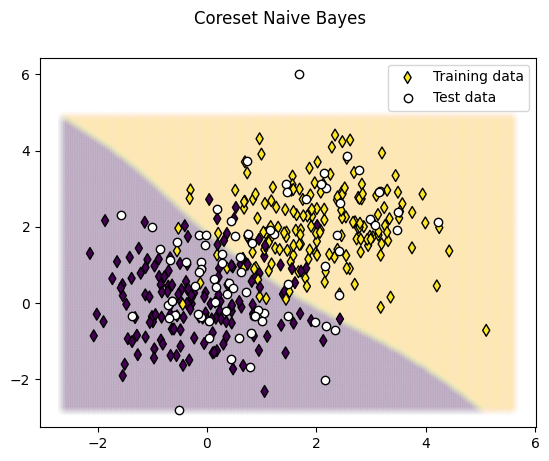

In [13]:
main()

The coloured regions of the graph represent the regions in which the model predicts either class.